# Stock prices prediction

In this notebook, we'll compare different methods to predict stock prices. Methods for time series forecasting are not only used in finance, they are everywhere. Check this excellent [video](https://www.youtube.com/watch?v=JntA9XaTebs&t=2s) for examples of applications.

The aim is to study two approaches:

* statistical 
* machine learning 

Data are from Quandl API, a financial data provider.

In [1]:
# iconic trio for data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import get_quandl_api_key

%matplotlib inline

# python module for quandl, a financial data provider
import quandl

# statistics module
import statsmodels.api as sm

In [2]:
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['font.size'] = 22

In [3]:
# set up a client to the Quandl API
quandl_api_key = get_quandl_api_key()
quandl.ApiConfig.api_key = quandl_api_key
quandl_code = "EOD/NKE" # code for the Nike Inc. (New York Stock Exchange)

# get the data 
nike_data = quandl.get(quandl_code)

In [4]:
nike_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1980-12-02,11.50,11.75,11.50,11.50,786800.0,0.0,1.0,0.060487,0.061802,0.060487,0.060487,100710400.0
1980-12-03,11.38,11.38,11.25,11.25,196700.0,0.0,1.0,0.059856,0.059856,0.059172,0.059172,25177600.0
1980-12-04,11.62,11.75,11.62,11.62,177300.0,0.0,1.0,0.061118,0.061802,0.061118,0.061118,22694400.0
1980-12-05,11.25,11.25,11.00,11.00,59300.0,0.0,1.0,0.059172,0.059172,0.057857,0.057857,7590400.0
1980-12-08,10.50,10.50,10.38,10.38,42300.0,0.0,1.0,0.055227,0.055227,0.054596,0.054596,5414400.0


More info on the data we use right [here](https://www.quandl.com/data/EOD/NKE-Nike-Inc-NKE-Stock-Prices-Dividends-and-Splits). For our purpose, we are going to only use the 'Close' column since it is heavily correlated with other columns and we have to choose one among them.
We are lucky to have more than 30 years of historical data of good quality.

In [5]:
stock_price = nike_data['Close']
stock_price.describe()

count    9628.000000
mean       55.691132
std        27.151835
min         6.870000
25%        39.600000
50%        56.500000
75%        74.837500
max       134.330000
Name: Close, dtype: float64

So we have more than 9620 data points. On average the stock price is about 55 dollars.

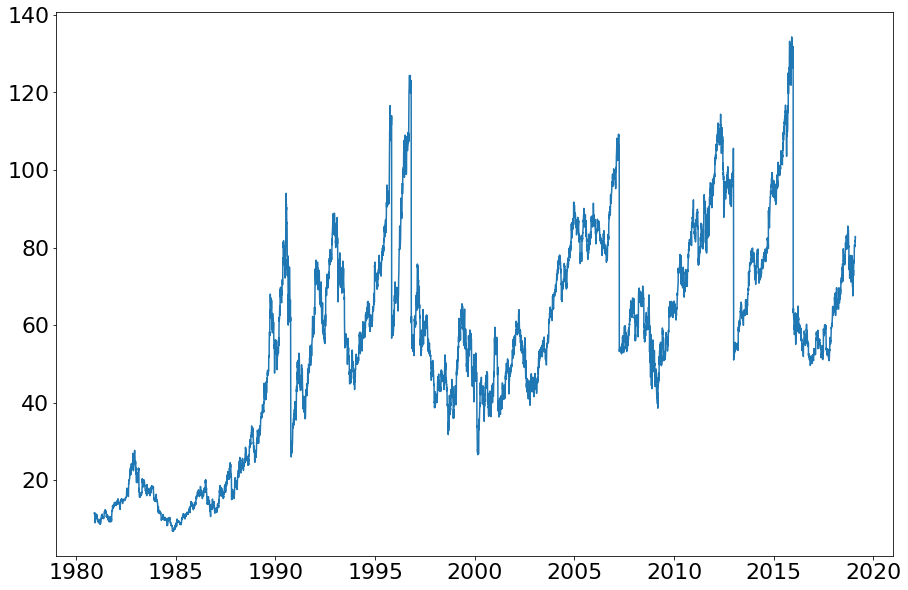

In [6]:
sns.lineplot(data = stock_price, markers = True)

## Statistics
There are several statistical approches to model time series and predict the future.
Before applying a model, we need to study the data we have. We compute several metrics.

In [7]:
decomposition = sm.tsa.seasonal_decompose(stock_price, model='additive', freq=300)


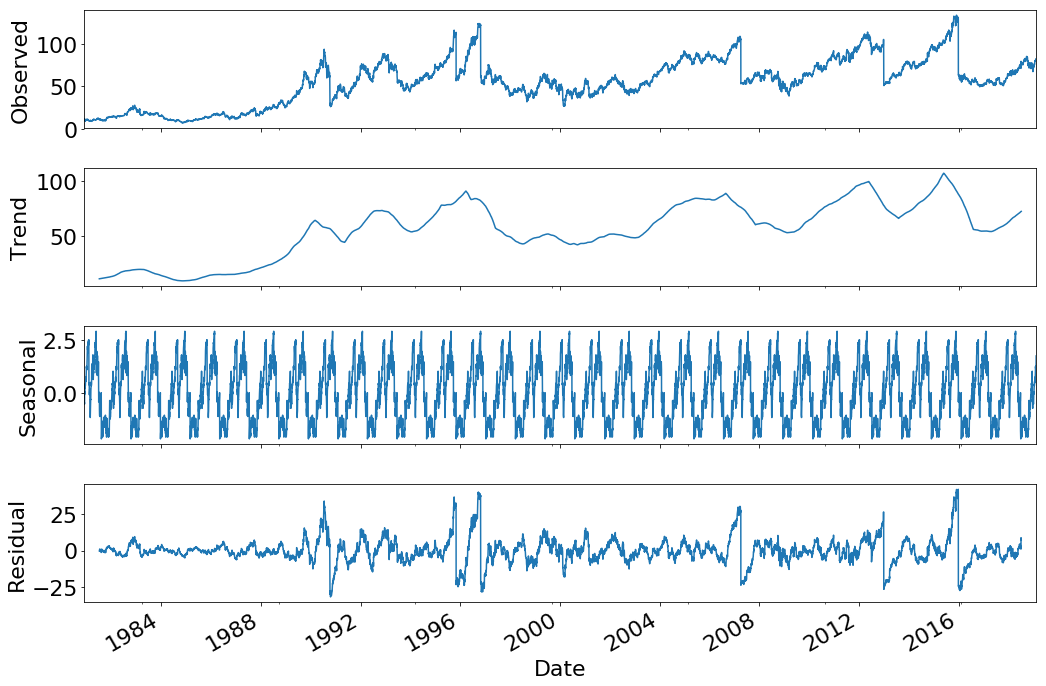

In [8]:
fig = decomposition.plot()

Then, most of the models are made on the assumption of stationarity.
A time series is said stationay if:
* the mean remains constant over time
* the variance too
* the autocovariance does not depend on the time

To verify the stationarity, we can use a statistical test. A good one is the Dickey Fuller test.

### The Dickey Fuller test

The Dickey-Fuller test is part of the statistical toolkit of **hypothesis testing**. A **statistical hypothesis test** is a method of statistical inference. It allows us to better know the properties of the data set we have and is commonly used in data science / analysis.

Basically, we make two hypotheses:
* the **null hypothesis**. Ex: means of two samples are equals, random variables are independant, the distribution is normal, the time series is stationary ...
* the **alternate hypothesis**. Ex: means of two samples are different, there exists a relationship between random variables, the distribution is not normal, the time series is not stationary ...

The two are compared and the aim is to determine if we **reject** or **accept** the null hypothesis. Note that the hypotheses are imposed by the test. We also define a threshold $\alpha$, commonly set to 0.05 or 0.01. We compare the value obtained with this **significance level** to conclude. 
There are lots of statistical tests. For example:
- [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)
- [Z-test](https://en.wikipedia.org/wiki/Z-test)
- [Shapiro test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)

Fortunately, we don't have to code a statistical test ourself and we can use functions already well coded and tested by the open source community.

In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):
    """test the stationarity of a time series using the augmented Dickey Fuller test.
    See the documentation for the object returned."""
    results = adfuller(x)
    print(f"Test statistic: {results[0]:.3f}")
    print(f"p-value: {results[1]:.3f}")
    print(f"Number of lags used: {results[2]}")
    print(f"Critical value, 1 %: {results[4]['1%']:.3f}")
    print(f"Critical value, 5 %: {results[4]['5%']:.3f}")
    
test_stationarity(stock_price)

Test statistic: -3.227
p-value: 0.018
Number of lags used: 2
Critical value, 1 %: -3.431
Critical value, 5 %: -2.862


So our test statistic is out of the acceptation interval and the p-value is less than the risk of 5 %, so we reject the null hypothesis. Our time series is not stationary. It is easier to see it graphically.

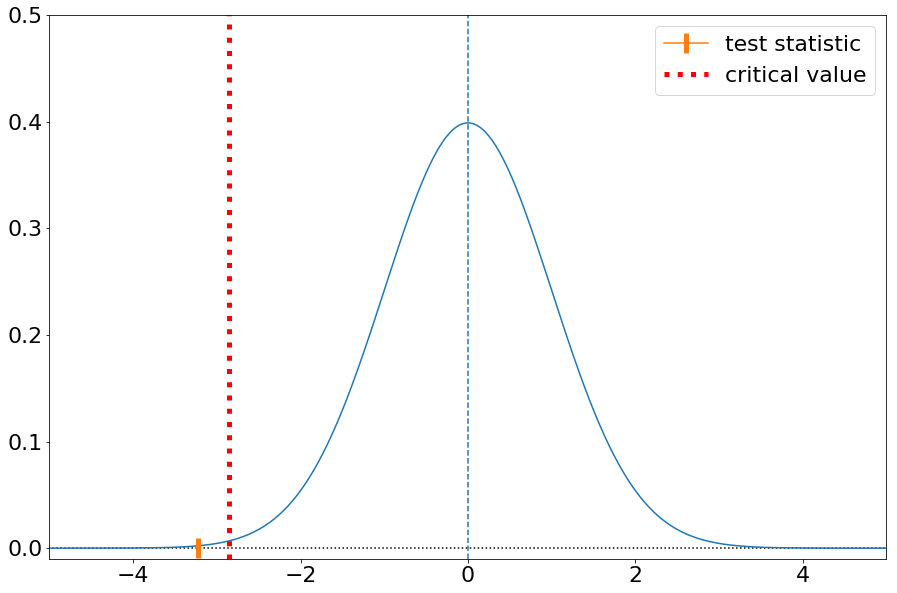

In [11]:
from scipy.stats import norm

plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['font.size'] = 22

# generate 500 points between -5 and 5
x = np.linspace(-5, 5, 500)

# get for each x in [-5, 5] the corresponding value by the normal distribution
y = norm.pdf(x, loc=0, scale=1)

# plot the bell curve
plt.plot(x, y)

# a few changes to clarify the visualization
plt.xlim([-5,5])
plt.ylim([-0.01,0.5])
plt.hlines(0, xmin=-10, xmax=10, linestyle='dotted')
plt.axvline(linestyle='dashed')

# plot the test statistic
plt.plot(-3.22, 0, marker='|', markersize=20, markeredgewidth=5, label='test statistic')

# plot a vertical line corresponding to the critical value
plt.axvline(-2.86, color='red', linestyle='dotted', linewidth=5, label='critical value')

# display the legend of lines and points
plt.legend()

As shown above, we see that the **test statistic** is ouside the interval where we accept **the null hypothesis**. The value is less than the **critical value**.

### Seasonality

When you explore time series data, it is a good habit to check for **seasonality**. You need this information for modeling. There can be a monthly seasonality, a weekly seasonality and so on ... Intuitively, we can guess there won't be any seasonality because stock prices don't depend on the time of the year or on the day we are, they depend on the company **current events** like the decisions made, the last financial reports and so on.

To check if there is some fluctuation that depends on the time of the year, we can look at boxplots. A **boxplot** is used to quickly get **descriptive statistics** like the **minimum, the maximum and the quartiles** of a **sample** or a **population**. we can compare the boxplots and see if there is significant differences among them.

We'll check whether the stock price depends on:
* the month
* the day of the month

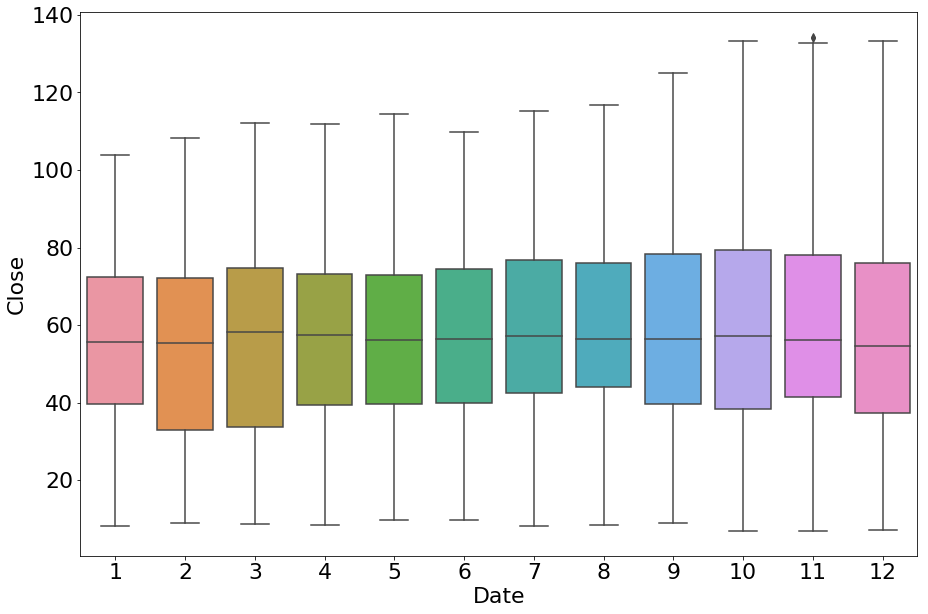

In [12]:
sns.boxplot(stock_price.index.month, stock_price)

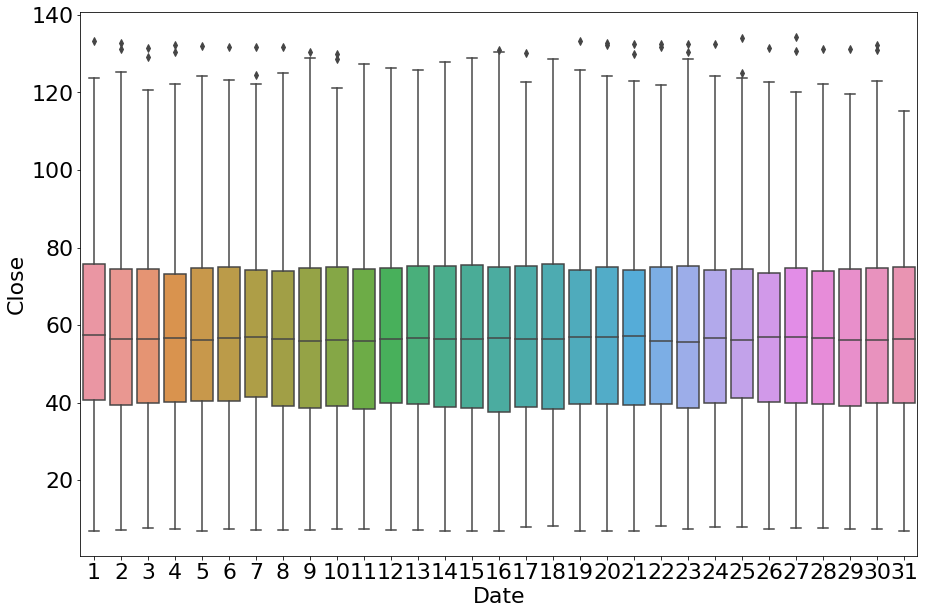

In [13]:
sns.boxplot(stock_price.index.day, stock_price)

We can see that the stock prices look roughly the same. So there is no link between the month or the day of the month and the stock price.

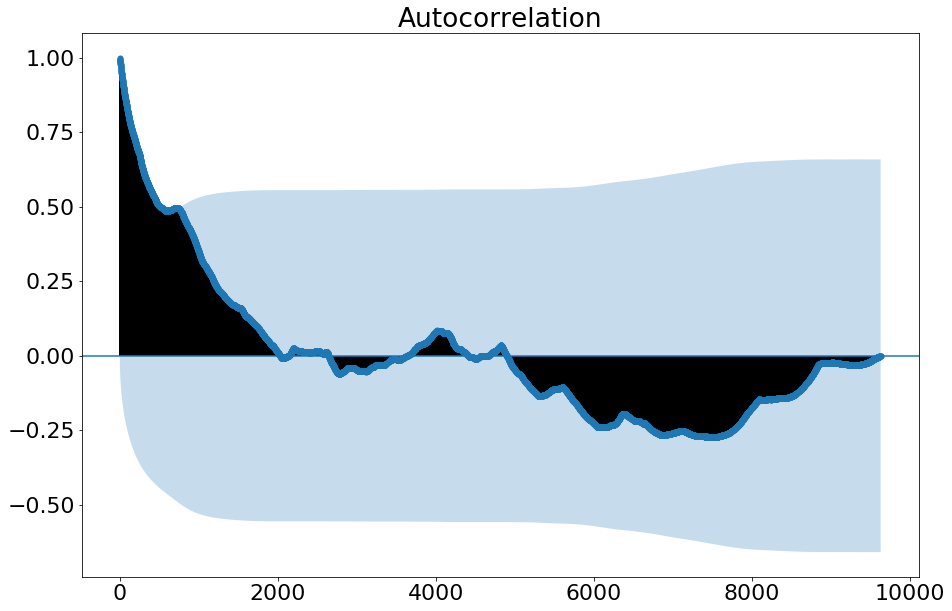

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

fig = plot_acf(stock_price)